## Table of Contents

* [Setup & Imports](#imports)
* [Reproducibility study](#4.1)
    * [Qualitative evaluation of counterfactual samples](#qual-eval-cf-samples) (HQC)
    * [Evaluating invariant classifiers](#eval-inv-clf) (ODR)
        * [Experiments on MNISTs](#repr-mnist)
        * [Experiments on ImageNet-mini](#repr-in-mini)
    * [Loss Ablation](#loss-ablation) (IBR)
* [Additional experiments and analyses](#add-expts)
    * [Explainability analysis on MNISTs](#expl-mnist)
    * [Explainability analysis on ImageNet-mini](#expl-in-mini)
    * [Robustness to OOD generalization](#ood)

## Setup & Imports  <a class="anchor" id="imports"></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Download data

The ImageNet-mini dataset needs to be downloaded from Kaggle. Please export your Kaggle credentials using the following command. The key is the Kaggle API key and can be found in your account settings.
```sh
export KAGGLE_USERNAME=<your_username>
export KAGGLE_KEY=<your_key>
```

Or alternatively, you can download your API key `kaggle.json` file and put it here `~/.kaggle/kaggle.json`.

> Note: Downloading all datasets takes about 20 mins and needs about 7GB of free space. In case the download fails at some point, you can re-run the cell, it will not download datasets already downloaded


In [ ]:
!python ../setup/download_datasets.py

This should download datasets for both `mnists` and `imagenet` tasks.

For MNISTs, the folder structure is as follows:
```sh
mnists/data
├── colored_mnist
└── textures
    ├── background
    └── object

4 directories
```

For ImageNet, the folder structure is as follows:
```sh
imagenet/data
├── cue_conflict
├── in-a
├── in-mini
├── in-sketch
├── in-stylized
└── in9

6 directories
```

### Download model weights

> Note: This takes < 5 mins to run and needs about 6GBs of free space. In case the download fails at some point, you can re-run the cell, it will not download model weights already downloaded.

In [9]:
!python ../setup/download_weights.py

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/u/0/uc?id=1VkKexkWh5SeB8fgxAZxLKgmmvDXhVYUy&export=downloadl 

mv: rename u2net.pth to imagenet/weights/u2net.pth: No such file or directory
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/u/0/uc?id=12yVFHPUjKmUFGnO2D4xVlTSpF8CUj136&export=download 

mv: cgn.pth: No such file or directory
--2022-05-18 19:38:33--  https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-256-pytorch_model.bin
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.6
Connecting to s3.amazonaws.com (s3.amazonaws

This will download the weights for all tasks.

```bash
imagenet/weights/
├── biggan256.pth
├── cgn.pth
├── u2net.pth
├── :
└── resnet50_from_scratch_model_best.pth.tar

4 files
```

## Section 4.1. Reproducibility study <a class="anchor" id="4.1"></a>

### Qualitative evaluation of counterfactual samples <a class="anchor" id="qual-eval-cf-samples"></a>

**Addressed Claim: High-quality counterfactuals (HQC)**


* Relevant section in the paper: Section 4.1.
* Relevant figures in the paper: Figure 2 and 3 

In [10]:
from counterfactual_mnist import main as mnist_main
from counterfactual_imagenet import main as imagenet_main

'colored_MNIST_train.pth' already exist, skipping..
'colored_MNIST_test.pth' already exist, skipping..
'colored_MNIST_counterfactual_samples.pth' already exist, skipping..
'double_colored_MNIST_train.pth' already exist, skipping..
'double_colored_MNIST_test.pth' already exist, skipping..
'double_colored_MNIST_counterfactual_samples.pth' already exist, skipping..
'wildlife_MNIST_train.pth' already exist, skipping..
'wildlife_MNIST_test.pth' already exist, skipping..
'wildlife_MNIST_counterfactual_samples.pth' already exist, skipping..


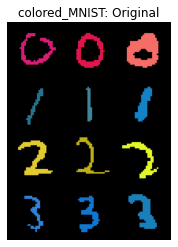

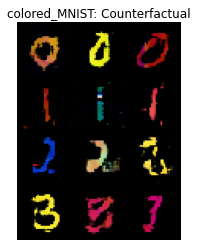

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


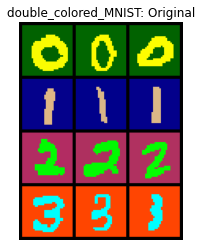

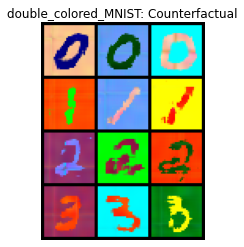

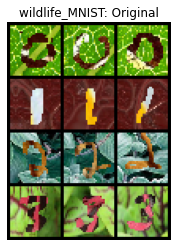

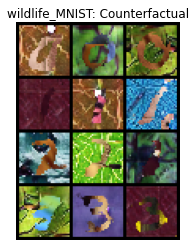

In [11]:
mnist_main(dataset_size=100, no_cfs=1)

Saving data to imagenet/data/2022_05_18_19_RUN_NAME_trunc_0.5


100%|██████████| 6/6 [01:20<00:00, 13.34s/it]


                        0            1            2                3  \
shape_cls           racer  trench coat   mud turtle             vase   
texture_cls  analog clock          cab  cauliflower  Indian elephant   
bg_cls             toucan   coral reef     mushroom              alp   

                         4           5  
shape_cls         malinois      barrel  
texture_cls   horned viper  piggy bank  
bg_cls       garden spider        ibex  

--= Generated LaTeX table: =--
\begin{tabular}{lllllll}
\toprule
shape\_cls   &         racer &  trench coat &   mud turtle &             vase &       malinois &      barrel \\
texture\_cls &  analog clock &          cab &  cauliflower &  Indian elephant &   horned viper &  piggy bank \\
bg\_cls      &        toucan &   coral reef &     mushroom &              alp &  garden spider &        ibex \\
\bottomrule
\end{tabular}

Saving counterfactuals plot to /Users/spyros/UvA_AI/DL2/code/media/figures/qualitative/qualitative_imagenet.pdf..


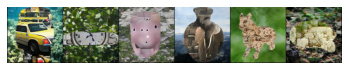

In [12]:
imagenet_main()

### Evaluating invariant classifiers <a class="anchor" id="eval-inv-clf"></a>

**Addressed Claim: Out-of-Distribution Robustness (ODR)**

#### Experiments on MNISTs <a class="anchor" id="repr-mnist"></a>

* Relevant tables in paper: Table 2

**Step 1**: Prepation - Run experiments on GPUs before visualizing results

> **Note**: It might take a long time to run this on a CPU machine (~40 mins). Instead, we would recommend
> running it on a GPU machine using the following instructions. That will run and generate all results
> and then you could run the cell below which will display all the results. We give instructions to run on a cluster managed by `Slurm`. In case you can get terminal access to GPU machines, you can run the individual scripts (look at the job files to check the commands).

**Running using cached models wherever necessary**

Follow the instruction to run it on a GPU on a cluster. 

1. We have created a job script `run_mnist.job`.
    Please change it appropriately, if needed, to run on a GPU.

2. Run the job script using 

    ```sh
    cd /path/to/repo/experiments/
    sbatch run_mnist.job
    ```
    You can check logs in `slurm_output_*.out` files.

3. After these steps are done, you can run the following cells that will display the result.

> This step takes about 20-25 mins to run on a GPU with 2 CPUs. Please let this step finish before running the cells.


**Re-running without using any cached models.**

The previous steps will generate CF data and load classification results from cache. If you want to run all these steps from scratch, you need to change `ignore_cache=True` in the following line in `mnist_pipeline.py` and follow the same steps as above.
```python
df = run_experiments(seed=0, ignore_cache=False)
```
You do not need to change the cell below.

**Step 2**: Replication of Table 2

In [13]:
from mnist_pipeline import run_experiments

In [14]:
# here, it is needed to pass `ignore_cache=False` since the results must be generated
# from the previous step, thus you only need to run this as it is
df = run_experiments(seed=0, show=False, ignore_cache=False)

::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'colored_MNIST'}
Train Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/data/colored_MNIST_train.pth.
Test Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/data/colored_MNIST_test.pth.
Results for classifier already exist: mnists/experiments/classifier_colored_MNIST_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/gan_colored_MNIST/weights/ckp.pth'}
python /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/generate_data.py --dataset colored_MNIST  --weight_path /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/gan_colored_MNIST/weights/ckp.pth
Namespace(dataset='colored_MNIST', weight_path='/Users/spyros/UvA_AI/DL2/code/cgn_frame

100%|██████████| 500/500 [01:05<00:00,  7.69it/s]


x shape torch.Size([50000, 3, 32, 32]), y shape torch.Size([50000])
Results for classifier already exist: mnists/experiments/classifier_colored_MNIST_gan_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_colored_MNIST/weights/ckp.pth'}
python /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/generate_data.py --dataset colored_MNIST  --weight_path /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_colored_MNIST/weights/ckp.pth
Namespace(dataset='colored_MNIST', weight_path='/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_colored_MNIST/weights/ckp.pth', dataset_size=50000.0, no_cfs=1)
initialize network with orthogonal
Generating the counterfactual colored_MNIST of size 50000.0


100%|██████████| 500/500 [05:54<00:00,  1.41it/s]


x shape torch.Size([50000, 3, 32, 32]), y shape torch.Size([50000])
Results for classifier already exist: mnists/experiments/classifier_colored_MNIST_counterfactual_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/gan_colored_MNIST/weights/ckp.pth', 'combined': True}
Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/data/colored_MNIST_gan.pth.
Results for classifier already exist: mnists/experiments/classifier_colored_MNIST_gan_combined_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_colored_MNIST/weights/ckp.pth', 'combined': True}
Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_framewo

100%|██████████| 500/500 [01:03<00:00,  7.85it/s]


x shape torch.Size([50000, 3, 32, 32]), y shape torch.Size([50000])
Results for classifier already exist: mnists/experiments/classifier_double_colored_MNIST_gan_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'double_colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_double_colored_MNIST/weights/ckp.pth'}
python /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/generate_data.py --dataset double_colored_MNIST  --weight_path /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_double_colored_MNIST/weights/ckp.pth
Namespace(dataset='double_colored_MNIST', weight_path='/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_double_colored_MNIST/weights/ckp.pth', dataset_size=50000.0, no_cfs=1)
initialize network with orthogonal
Generating the counterfactual double_colored_MNIST of size 50000.0


100%|██████████| 500/500 [05:36<00:00,  1.49it/s]


x shape torch.Size([50000, 3, 32, 32]), y shape torch.Size([50000])
Results for classifier already exist: mnists/experiments/classifier_double_colored_MNIST_counterfactual_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'double_colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/gan_double_colored_MNIST/weights/ckp.pth', 'combined': True}
Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/data/double_colored_MNIST_gan.pth.
Results for classifier already exist: mnists/experiments/classifier_double_colored_MNIST_gan_combined_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'double_colored_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_double_colored_MNIST/weights/ckp.pth', 'combined': True}
Dataset already gener

100%|██████████| 500/500 [01:04<00:00,  7.81it/s]


x shape torch.Size([50000, 3, 32, 32]), y shape torch.Size([50000])
Results for classifier already exist: mnists/experiments/classifier_wildlife_MNIST_gan_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'wildlife_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_wildlife_MNIST/weights/ckp.pth'}
python /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/generate_data.py --dataset wildlife_MNIST  --weight_path /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_wildlife_MNIST/weights/ckp.pth
Namespace(dataset='wildlife_MNIST', weight_path='/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_wildlife_MNIST/weights/ckp.pth', dataset_size=50000.0, no_cfs=1)
initialize network with orthogonal
Generating the counterfactual wildlife_MNIST of size 50000.0


100%|██████████| 500/500 [05:53<00:00,  1.42it/s]


x shape torch.Size([50000, 3, 32, 32]), y shape torch.Size([50000])
Results for classifier already exist: mnists/experiments/classifier_wildlife_MNIST_counterfactual_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'wildlife_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/gan_wildlife_MNIST/weights/ckp.pth', 'combined': True}
Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/data/wildlife_MNIST_gan.pth.
Results for classifier already exist: mnists/experiments/classifier_wildlife_MNIST_gan_combined_seed_0/test_accs.pth
::::: Experimental setup :::::
Train generative model: False
Generate data: True
Args: {'seed': 0, 'dataset': 'wildlife_MNIST', 'weight_path': '/Users/spyros/UvA_AI/DL2/code/cgn_framework/mnists/experiments/cgn_wildlife_MNIST/weights/ckp.pth', 'combined': True}
Dataset already generated at /Users/spyros/UvA_AI/DL2/code/cgn_

In [15]:
df.index = ["Original", "GAN", "CGN", "Original + GAN", "Original + CGN"]

In [16]:
# show the results    
df.astype(float).round(1)

,colored_MNIST-train,colored_MNIST-test,double_colored_MNIST-train,double_colored_MNIST-test,wildlife_MNIST-train,wildlife_MNIST-test
Original,99.7,38.1,100.0,10.4,100.0,10.7
GAN,99.6,31.3,100.0,10.1,100.0,11.0
CGN,99.4,93.1,94.8,86.6,95.0,81.1
Original + GAN,99.6,39.5,100.0,10.5,100.0,10.9
Original + CGN,99.3,95.5,96.9,85.2,97.1,65.6


#### Experiments on ImageNet-mini <a class="anchor" id="repr-in-mini"></a>

* Relevant tables in the paper: Table 3 and 4

**Step 1**: Prepation - Run experiments on GPUs before visualizing results

**Running using cached models wherever necessary**

Follow the instruction to run it on a GPU on a cluster. 

1. We have created a job script `run_imagenet.job`.
    Please change it appropriately, if needed, to run on a GPU.

2. Run the job script using 

    ```sh
    cd /path/to/repo/experiments/
    sbatch run_imagenet.job
    ```
    You can check logs in `slurm_output_*.out` files.

3. After these steps are done, you can run the following cells that will display the result.

> This step takes about 5 mins to run. Please let this step finish before running the cells.


**Re-running without using any cached models.**

The previous steps will generate CF data and load classification results from cache. If you want to run all these steps from scratch, you need to change `ignore_cache=True` and `generate_cf_data=True` in the following line in `experiments/imagenet_pipeline.py` and follow the same steps as above.

```python
metrics_clf, df_ood = run_experiments(seed=0, generate_cf_data=False, disp_epoch=34, ignore_cache=False)
```

> Note: This section involves generating counterfactual samples and training classifiers on IN-mini.
> Generating CF samples can take about 3.5 hours and training the classifier about 2 hours on a GPU.

**Step 2**: Results for Table 3 and 4 from the paper

In [17]:
from imagenet_pipeline import run_experiments

In [18]:
# temporarily showing results for 0th epoch
metrics_clf, df_ood = run_experiments(seed=0, disp_epoch=34)

Since generate_cf_data=False, skipping CF dataset generation.
Loading results for classification and OOD experiments from cache.

::::: Training classifier :::::

::::: Classifier already trained, skipping :::::
Loading results for epoch 34 from /Users/spyros/UvA_AI/DL2/code/cgn_framework/imagenet/experiments/classifier__in-mini-classifier/epochwise_metrics/epoch_34.pt

::::: Evaluating OOD :::::

::::: Running cgn-ensemble on in-mini...
::: Result file /Users/spyros/UvA_AI/DL2/code/cgn_framework/imagenet/experiments/ood_eval/cgn-ensemble_in-mini/results_seed_0.json already exists & --ignore_cache=False
::::: Running cgn-ensemble on in-a...
::: Result file /Users/spyros/UvA_AI/DL2/code/cgn_framework/imagenet/experiments/ood_eval/cgn-ensemble_in-a/results_seed_0.json already exists & --ignore_cache=False
::::: Running cgn-ensemble on in-stylized...
::: Result file /Users/spyros/UvA_AI/DL2/code/cgn_framework/imagenet/experiments/ood_eval/cgn-ensemble_in-stylized/results_seed_0.json alrea

In [19]:
# construct Table 3 of the paper

heads = ["shape", "texture", "bg"]
table_3 = pd.DataFrame(
    None,
    columns=["Shape bias", "Top 1", "Top 5"],
    index=[f"IN-mini + CGN/{h}" for h in heads],
)
for i, h in enumerate(heads):
    table_3.at[f"IN-mini + CGN/{h}", "Shape bias"] = metrics_clf[f"shape_biases/{i}_m_{h}_bias"]
    table_3.at[f"IN-mini + CGN/{h}", "Top 1"] = metrics_clf[f"acc1/1_real"]
    table_3.at[f"IN-mini + CGN/{h}", "Top 5"] = metrics_clf[f"acc5/1_real"]

table_3["Shape bias"] *= 100.0
table_3 = table_3.astype(float).round(1)

In [20]:
table_3

,Shape bias,Top 1,Top 5
IN-mini + CGN/shape,49.1,56.2,79.1
IN-mini + CGN/texture,20.5,56.2,79.1
IN-mini + CGN/bg,25.7,56.2,79.1


In [21]:
# construct Table 4 of the paper
table_4 = pd.DataFrame(
    None,
    columns=["IN-9", "Mixed-same", "Mixed-rand", "BG-gap"],
    index=["IN-mini + CGN"],
)

col_to_key = {
    "IN-9": "in_9_acc1_original/shape_texture",
    "Mixed-same": "in_9_acc1_mixed_same/shape_texture",
    "Mixed-rand": "in_9_acc1_mixed_rand/shape_texture",
    "BG-gap": "in_9_gaps/bg_gap",
}

for c in table_4.columns:
    assert col_to_key[c] in metrics_clf
    key = col_to_key[c]
    table_4.at["IN-mini + CGN", c] = metrics_clf[key]

table_4 = table_4.astype(float).round(1)

In [22]:
table_4

,IN-9,Mixed-same,Mixed-rand,BG-gap
IN-mini + CGN,86.8,73.2,68.3,4.9


### Loss ablation <a class="anchor" id="loss-ablation"></a>

**Addressed Claim: Inductive Bias Requirements (IBR)**

* Relevant section in the paper: `Evaluating loss ablation` within Section 4.1.
* Relevant table in paper: Table 2

In [23]:
from ablation_study import run_experiments

for loss_name, inception, avg_mask, sd_mask in run_experiments(ignore_cache=False):
    print(f"for {loss_name} inception_score = {inception} and mu_mask = {avg_mask}")

for shape-ablation inception_score = (109.65711660626205, 2.3383855406694494) and mu_mask = 0.26194179433437603
for text-ablation inception_score = (187.08312054049514, 1.0216010928361214) and mu_mask = 0.4107667627471965
for bg-ablation inception_score = (210.33702797783855, 0.828793968409073) and mu_mask = 0.06363586789793407
for rec-ablation inception_score = (17.172373577238293, 0.38844727562504033) and mu_mask = 0.3463172117804352


### Additional experiments and analyses <a class="anchor" id="add-expts"></a>

#### Explainability analysis on MNISTs <a class="anchor" id="expl-mnist"></a>

* Relevant sections in the paper: 4.2.2
* Relevant figures in the paper: Figure 5 and 6

In [34]:
# from mnist_analysis import run_analyses

In [35]:
# run_analyses(
#     datasets=["colored_MNIST", "double_colored_MNIST", "wildlife_MNIST"],
#     debug=False,
#     show=True,
#     ignore_cache=False,
# )

#### Explainability analysis on ImageNet-mini <a class="anchor" id="expl-in-mini"></a>

* Relevant figures in the paper: Figure 7

In [30]:
# from gradio_demo import init_gradio_module

In [33]:
# cgn_gradio = init_gradio_module(launch=True, share=True)

#### Robustness to out-of-distribution generalization <a class="anchor" id="ood"></a>

* Relevant tables in the paper: Table 5

In [26]:
df_ood = df_ood.astype(float).round(2)

In [27]:
df_ood

,in-mini,in-a,in-stylized,in-sketch
cgn-ensemble,56.79,1.39,17.19,11.77
resnet50,75.58,3.40,19.22,24.09


### Appendix

#### Ablation on number of counterfactuals

In [28]:
# def plot_mnist_ablation_on_cfs(
#         file,
#         datasets=["colored_MNIST", "double_colored_MNIST", "wildlife_MNIST"],
#     ):
#     CF_ratios = [1, 5, 10, 20]
#     dataset_sizes = [10000, 100000, 1000000]

#     with open(file, "r") as f:
#         results = json.load(f)

#     fig, axs = plt.subplots(1, 3, figsize=(16,5))
#     plt.setp(axs, xticks=[0, 1, 2], xticklabels=[r'$10^4$', r'$10^5$', r'$10^6$'])

#     for i, dataset in enumerate(datasets):
#         for CF_ratio in CF_ratios:
#             # Skip the CF_ratio of 20 for the colored MNIST dataset, as there are only 10 possible colors
#             # per shape.
#             if CF_ratio == 20 and dataset == "colored_MNIST":
#                 continue

#             line = []
#             for size in dataset_sizes:
#                 line.append(results[f"{dataset}_counterfactual_{size}_{CF_ratio}"])
#             axs[i].plot(np.arange(3), line, label=f'CF ratio = {CF_ratio}', marker='o')
#             axs[i].set_xlabel("Num Counterfactual Datapoints")
#             axs[i].set_ylabel("Test Accuracy (%)")
#             axs[i].grid(True)
#             axs[i].legend()
#         axs[i].set_title(datasets[i])

#     plt.savefig('../media/figures/figure7_reproduced.pdf', bbox_inches='tight')
#     plt.show()


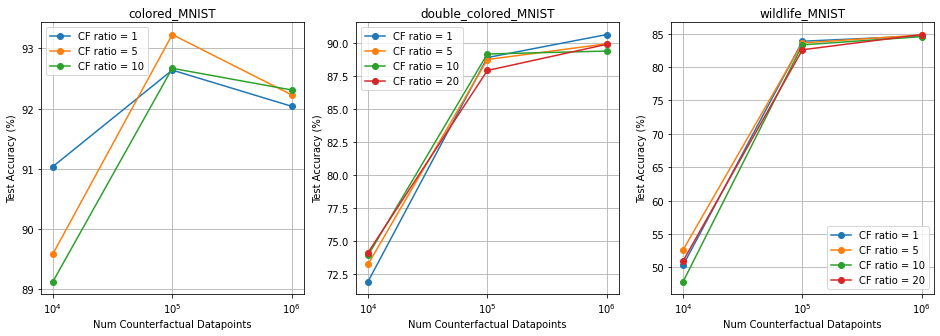

In [29]:
# results_path = "../experiments/results/cache/mnist_ablation_on_cfs.json"
# plot_mnist_ablation_on_cfs(results_path)